# 解决过拟合和欠拟合
- 控制参数个数
- 控制参数选择范围

# 权重衰退
- 均方范数作为限制条件：||w||2<=θ ，限制参数大小，部分参数接近0->0
- 拉格朗日乘数作为罚项：λ||w||2/2  λ=0，无限制
- 更新参数 $W_1$ =(1-λη)$W_0$ -η梯度 λη<1所以叫权重衰退

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
n_train,n_test,num_inputs,batch_size = 20,100,200,5 #复杂模型，简单数据
true_w,true_b = torch.ones((num_inputs,1))*0.01,0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size,is_train=False)

In [5]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

In [6]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [33]:
def l1_penalty(w):
    return torch.sum(abs(w))

In [40]:
def train(lambd,penalty):
    w,b = init_params()
    net,loss = lambda X: d2l.linreg(X,w,b), d2l.squared_loss
    num_epochs, lr = 100,0.003
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])

    for epoch in range(num_epochs):
        for X,y in train_iter:
            #with torch.enable_grad():
            l = loss(net(X),y) + lambd * penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch+1)%5 == 0:
            animator.add(epoch+1,(d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
    print('W的L2范数是： ', torch.norm(w).item())

W的L2范数是：  13.436614990234375


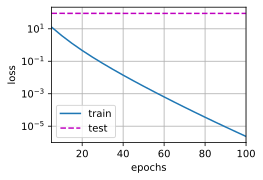

In [8]:
train(lambd=0)  # 过拟合，测试集上无效

W的L2范数是：  0.3737930357456207


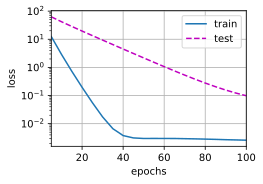

In [9]:
train(lambd=3)  # 测试集上有一定效果

W的L2范数是：  14.247153282165527


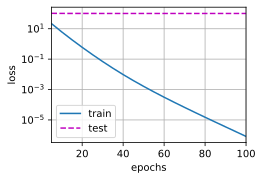

In [41]:
train(0,l1_penalty)

W的L2范数是：  0.07097861170768738


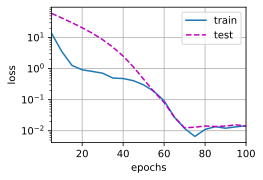

In [42]:
train(3,l1_penalty)

In [30]:
# 简洁实现  wd=1e-3 1e-4
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs,lr =100,0.003
    trainer = torch.optim.SGD(
        [{
            'params':net[0].weight,
            'weight_decay':wd  # 权重衰减
        },{
            'params':net[0].bias
        } ],lr=lr
    )
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # with torch.enable_grad():
            trainer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.730339050292969


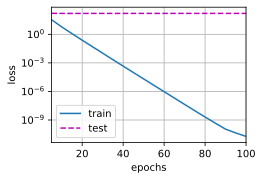

In [31]:
train_concise(0)

w的L2范数： 0.3933909237384796


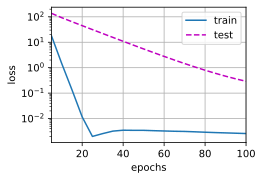

In [32]:
train_concise(3)